# LQR optimal control using `ldsctrlest`

This tutorial will be more comprehensive than the others, bringing together all of `cleo`'s main capabilities&mdash;electrode recording, optogenetics, and latency modeling&mdash;as well as introducing more sophisticated model-based feedback control. To achieve the latter, we will use the `ldsctrlest` Python bindings to the [`ldsCtrlEst` C++ library](https://cloctools.github.io/lds-ctrl-est/).

Preamble:

In [4]:
from brian2 import *
import matplotlib.pyplot as plt
import cleo

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
np.random.seed(1856)

## Network setup

As in the optogenetics tutorial, we'll use a trivial network of a small neuron group biased by Poisson input spikes. We'll use the exponential integrate-and-fire neuron model, which maintains simplicity while modeling an upward membrane potential swing when spiking.

In [5]:
n = 2
ng = NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", 10, 100 * Hz, 2.5 * mV)

net = Network(ng, input_group)

## Coordinates, stimulation, and recording

Here we assign coordinates to the neurons and configure the optogenetic intervention and recording setup:

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

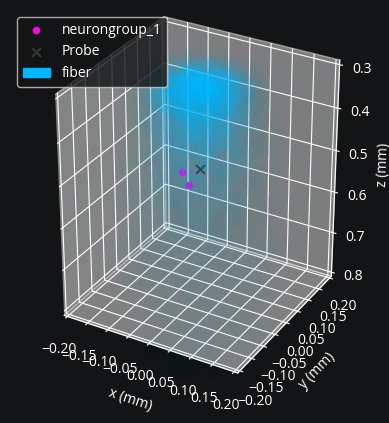

In [6]:
from cleo.coords import assign_coords_rand_rect_prism
from cleo.opto import *
from cleo.ephys import Probe, SortedSpiking

hor_lim = .05
assign_coords_rand_rect_prism(ng, xlim=(-hor_lim, hor_lim), ylim=(-hor_lim, hor_lim), zlim=(0.4, 0.6))

fiber = Light(
    name="fiber",
    light_model=fiber473nm(),
    coords=(0, 0, 0.3) * mm,
)

opsin = chr2_4s()

spikes = SortedSpiking(
    name="spikes",
    r_perfect_detection=40 * umeter,
    r_half_detection=80 * umeter,
    save_history=True,
)
probe = Probe(
    coords=[0, 0, 0.5] * mm,
    signals=[spikes],
)

cleo.viz.plot(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.2, 0.2),
    ylim=(-0.2, 0.2),
    zlim=(0.3, 0.8),
    devices=[probe, fiber],
    scatterargs={'alpha': 1}
)

Looks right. Let's set up the simulation and inject the devices:

In [7]:
sim = cleo.CLSimulator(net)
sim.inject(fiber, ng)
sim.inject(opsin, ng, Iopto_var_name='I')
sim.inject(probe, ng)

CLSimulator(io_processor=None, devices={Probe(brian_objects={<SpikeMonitor, recording from 'spikemonitor'>}, sim=..., name='Probe', signals=[SortedSpiking(name='spikes', brian_objects={<SpikeMonitor, recording from 'spikemonitor'>}, probe=..., r_perfect_detection=40. * umetre, r_half_detection=80. * umetre, cutoff_probability=0.01, save_history=True)], probe=NOTHING), Light(brian_objects=set(), sim=..., name='fiber', value=array([0.]), save_history=True, light_model=FiberModel(R0=100. * umetre, NAfib=0.37, wavelength=0.473 * umetre, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), coords=array([[  0.,   0., 300.]]) * umetre, direction=array([0., 0., 1.]), max_Irr0_mW_per_mm2=None, max_Irr0_mW_per_mm2_viz=None, default_value=array([0.])), FourStateOpsin(brian_objects={Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='opto_syn_ChR2_neurongroup_1'), NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='li

## Prepare controller
Our goal will be to control two neuron's firing rates simultaneously. To do this, we will use the LQR technique explained in [Bolus et al., 2021 ("State-space optimal feedback control of optogenetically driven neural activity)"](https://iopscience.iop.org/article/10.1088/1741-2552/abb89c/meta).

### Fit model
Our controller needs a model of the system's dynamics, which we can obtain by fitting to training data. We will generate training data using Gaussian random walk inputs. `ldsCtrlEst` is designed for data coming from an experiment, organized into trials, so we will run the simulation repeatedly, resetting after each run. Here $u$ represents the input and $z$ the spike output.

We will intentionally use very little training data so the importance of adaptive control will become apparent later on.

In [8]:
n_trials = 5
n_samp = 100
u = []
z = []
n_u = 1  # 1-dimensional input (just one optogenetic actuator)
n_z = 2  # we'll be controlling two neurons
for trial in range(n_trials):
    # one-sided normally distributed training data, stdev of 10 mW/mm2
    u_trial = 10*np.abs(np.random.randn(n_u, n_samp))
    u.append(u_trial)
    z.append(np.zeros((n_z, n_samp)))


The IO processor is simple enough here that we won't bother separating steps using :class:`~cleo.ioproc.ProcessingBlock` objects, which is recommended for more complex scenarios where modularity is more important.

In [9]:
from cleo.ioproc import LatencyIOProcessor

class TrainingStimIOP(LatencyIOProcessor):
    i_samp = 0
    i_trial = 0

    # here we just feed in the training inputs and record the outputs
    def process(self, state_dict, sample_time_ms):
        i, t, z_t = state_dict['Probe']['spikes']
        z[self.i_trial][:, self.i_samp] = z_t[:n_z]  # just first two neurons
        out = {'fiber': u[self.i_trial][:, self.i_samp]}
        self.i_samp += 1
        return out, sample_time_ms

training_stim_iop = TrainingStimIOP(sample_period_ms=1)
sim.set_io_processor(training_stim_iop)

for i_trial in range(n_trials):
    training_stim_iop.i_trial = i_trial
    training_stim_iop.i_samp = 0
    sim.run(n_samp*ms)
    sim.reset()

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'opto_syn_ChR2_neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


Now we have `u` and `z` in the form we need for `ldsctrlest`'s fitting functions: `n_trial`-length lists of `n` by `n_samp` arrays. We will now fit Gaussian linear dynamical systems using the SSID algorithm. See [the documentation](https://cloctools.github.io/lds-ctrl-est/) for more detailed explanations.

In [10]:
import ldsctrlest as lds
import ldsctrlest.gaussian as glds
n_x_fit = 2  # latent dimensionality of system
n_h = 50  # size of block Hankel data matrix
dt = 0.001  # timestep (in seconds)
u_train = lds.UniformMatrixList(u, free_dim=2)
z_train = lds.UniformMatrixList(z, free_dim=2)
ssid = glds.FitSSID(n_x_fit, n_h, dt, u_train, z_train)
fit, sing_vals = ssid.Run(lds.SSIDWt.kMOESP)

### Design controller

#### LQR optimal control

We now use the fit parameters to create the controller system and set additional parameters. The feedback gain, $ K_c $, is especially important, determining how the controller responds to the current "error"&mdash;the difference between where the system is (estimated to be) now and where we want it to be. The field of optimal control deals with how to design the controller so as to minimize a cost function reflecting what we care about.

With a linear system (obtained from the fitting procedure above) and quadratic per-timestep cost function $L$ penalizing distance from the reference $x^*$ and the input $u$

$$ L = \frac{1}{2} (x - x^*)^T Q (x - x^*) + \frac{1}{2} u^T R u $$

we can use the closed-form optimal solution called the Linear Quadratic Regulator (LQR).

$$ K = (R + B^T P B)^{-1}(B^T P A) \quad\quad u = -Kx$$

The $P$ matrix is obtained by numerically solving the discrete algebraic Riccati equation:

$$
P=A^{T} P A-\left(A^{T} P B\right)\left(R+B^{T} P B\right)^{-1}\left(B^{T} P A\right)+Q
$$

In [11]:
fit_sys = glds.System(fit)
# upper and lower bounds on control signal (optic fiber light intensity)
u_lb = 0  # mW/mm2
u_ub = 30  # mW/mm2
controller = glds.Controller(fit_sys, u_lb, u_ub)
# careful not to use this anymore since controller made a copy
del fit_sys

from scipy.linalg import solve_discrete_are
# cost matrices
# Q reflects how much we care about state error
# we use C'C since we really care about output error, not latent state
Q_cost = controller.sys.C.T @ controller.sys.C
R_cost = 1e-4 * np.eye(n_u)  # reflects how much we care about minimizing the stimulus
A, B = controller.sys.A, controller.sys.B
P = solve_discrete_are(A, B, Q_cost, R_cost) 
controller.Kc = np.linalg.inv(R_cost + B.T @ P @ B) @ (B.T @ P @ A)
controller.Print()


 ********** SYSTEM ********** 
x: 
        0
        0

P: 
   1.0000e-06            0
            0   1.0000e-06

A: 
   0.9932   0.0533
  -0.0490   0.9105

B: 
  -0.0653
   0.0489

g: 
   1.0000

m: 
        0
        0

Q: 
   0.5513  -0.9857
  -0.9857   2.0083

Q_m: 
   1.0000e-06            0
            0   1.0000e-06

d: 
        0
        0

C: 
  -0.0277   0.0196
  -0.0450  -0.0170

y: 
        0
        0

R: 
   0.1033   0.0055
   0.0055   0.1707

g_design :    1.0000

u_lb : 0
u_ub : 30


We now configure the `IOProcessor` to use our controller:

In [12]:
class CtrlLoop(LatencyIOProcessor):
    def __init__(self, samp_period_ms, controller, y_ref: callable):
        super().__init__(samp_period_ms)
        self.controller = controller
        self.sys = controller.sys
        self.y_ref = y_ref
        self.do_control = False  # allows us to turn on and off control

        # for post hoc visualization/analysis:
        self.u = np.empty((n_u, 0))
        self.x_hat = np.empty((n_x_fit, 0))
        self.y_hat = np.empty((n_z, 0))
        self.z = np.empty((n_z, 0))

    def process(self, state_dict, sample_time_ms):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z_t = z_t[:n_z].reshape((-1, 1))  # just first n_z neurons
        self.controller.y_ref = self.y_ref(sample_time_ms)

        u_t = self.controller.ControlOutputReference(z_t, do_control=self.do_control)
        out = {fiber.name: u_t.squeeze()}

        # record variables from this timestep
        self.u = np.hstack([self.u, u_t])
        self.y_hat = np.hstack([self.y_hat, self.sys.y])
        self.x_hat = np.hstack([self.x_hat, self.sys.x])
        self.z = np.hstack((self.z, z_t))

        return out, sample_time_ms + 3  # 3 ms delay


y_ref = 200 * dt  # target rate in Hz
ctrl_loop = CtrlLoop(
    samp_period_ms=1, controller=controller, y_ref=lambda t: np.ones((n_z, 1)) * y_ref
)

## Run the experiment

We'll now run the simulation with and without control to compare.

In [13]:
sim.set_io_processor(ctrl_loop)
T0 = 100
sim.run(T0*ms)

ctrl_loop.do_control = True
T1 = 350
sim.run(T1*ms)

WARNING    'dt' is an internal variable of group 'opto_syn_ChR2_neurongroup_1', but also exists in the run namespace with the value 0.001. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Now we plot the results to see how well the controller was able to match the desired firing rate:

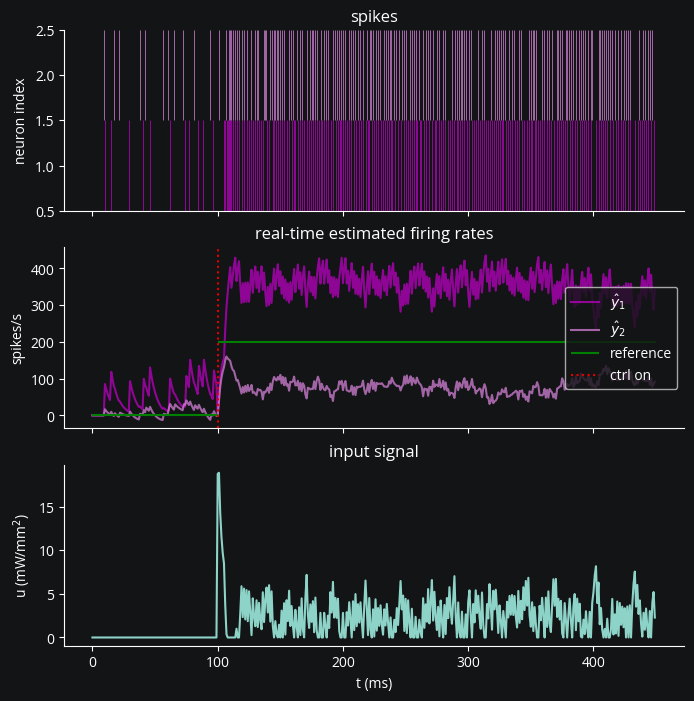

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
c1 = "#C500CC"
c2 = "#df87e1"
spikes1 = spikes.t_ms[spikes.i == 0]
spikes2 = spikes.t_ms[spikes.i == 1]
ax1.eventplot([spikes1, spikes2], lineoffsets=[1, 2], colors=[c1, c2], lw=0.5)
ax1.set(ylabel='neuron index', ylim=(0.5, 2.5), title='spikes')
ax2.set(ylabel='spikes/s', title='real-time estimated firing rates')
ax2.plot(ctrl_loop.y_hat[0]/dt, c=c1, alpha=0.7, label='$\hat{y}_1$')
ax2.plot(ctrl_loop.y_hat[1]/dt, c=c2, alpha=0.7, label='$\hat{y}_2$')
ax2.hlines(y_ref/dt, 100, T0+T1, color='green', label='reference')
ax2.hlines(0, 0, 100, color='green')
ax2.axvline(T0, c='xkcd:red', linestyle=':', label='ctrl on')
ax2.legend(loc="right")
ax3.plot(range(T0+T1), ctrl_loop.u.T)
ax3.set(xlabel='t (ms)', ylabel='u (mW/mm$^2$)', title='input signal');

Looks all right, but in addition to the system's estimated firing rate let's count the spikes over the control period to see how well we hit the target on average:

In [15]:
print("Results (spikes/second):")
print('baseline =', np.sum(ctrl_loop.z[:, :T0], axis=1)/(T0/1000))
print('target =', [y_ref*1000, y_ref*1000])
print('lqr achieved =', (np.sum(ctrl_loop.z[:, T0:T0+T1], axis=1)/(T1/1000)).round(1))

Results (spikes/second):
baseline = [110. 110.]
target = [200.0, 200.0]
lqr achieved = [557.1 465.7]


We can see that the system consistently underestimates the true firing rate.
And as we could expect, we weren't able to maintain the target firing rate with both neurons simultaneously since one was exposed to more light than the other. However, the controller was able to achieve something. See the appendix for how we can avoid overshooting with both neurons, which should be avoidable.

## Conclusion
As a recap, in this tutorial we've seen how to:
- inject optogenetic stimulation into an existing Brian network
- inject an electrode into an existing Brian network to record spikes
- generate training data and fit a Gaussian linear dynamical system to the spiking output using `ldsctrlest`
- configure an `ldsctrlest` LQR controller based on that linear system and design optimal gains
- use that controller in running a complete simulated feedback control experiment

## Appendix

### Adaptive control

ldsCtrlEst also provides an *adaptive* variation on LQR, capable of inferring state beyond our static, linear model and thus able to account for unmodeled disturbances and noise.
Let's see how it compares:

In [16]:
controller.sys.do_adapt_m = True  # enable adaptive disturbance estimation
# set covariance for the disturbance state μ
# larger values mean the system more readily ascribes changes to unmodeled disturbance 
controller.sys.Q_m = 1e-2 * np.eye(n_x_fit)
controller.control_type = lds.kControlTypeAdaptM  # enable adaptive control

In [17]:
ctrl_loop.sys.do_adapt_m = True
T2 = 350
sim.run(T2*ms)
T = T0 + T1 + T2

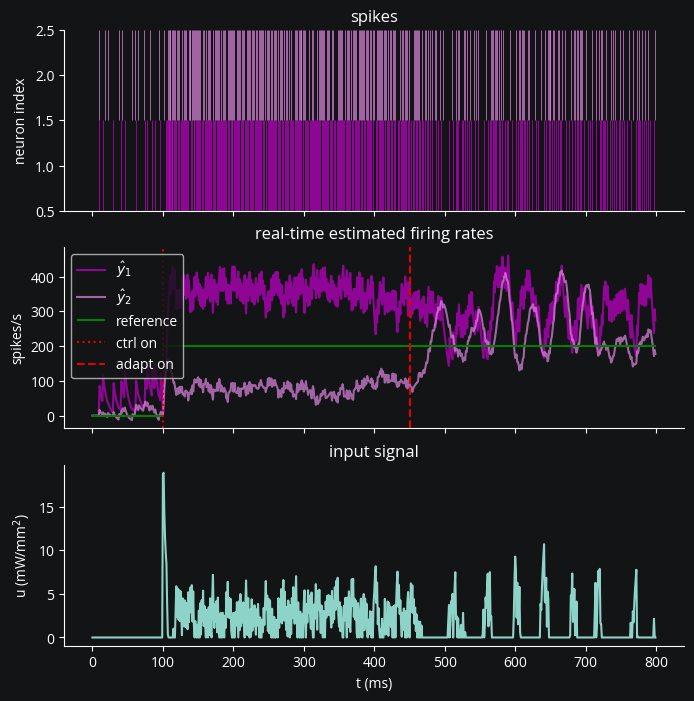

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
spikes1 = spikes.t_ms[spikes.i == 0]
spikes2 = spikes.t_ms[spikes.i == 1]
ax1.eventplot([spikes1, spikes2], lineoffsets=[1, 2], colors=[c1, c2], lw=0.5)
ax1.set(ylabel='neuron index', ylim=(.5, 2.5), title='spikes')
ax2.set(ylabel='spikes/s', title='real-time estimated firing rates')
ax2.plot(ctrl_loop.y_hat[0]/dt, c=c1, alpha=0.7, label='$\hat{y}_1$')
ax2.plot(ctrl_loop.y_hat[1]/dt, c=c2, alpha=0.7, label='$\hat{y}_2$')
ax2.hlines(y_ref/dt, 100, T, color='green', label='reference')
ax2.hlines(0, 0, 100, color='green')
ax2.axvline(T0, c='xkcd:red', linestyle=':', label='ctrl on')
ax2.axvline(T0+T1, c='xkcd:red', linestyle='--', label='adapt on')
ax2.legend(loc="upper left")
ax3.plot(range(T), ctrl_loop.u.T)
ax3.set(xlabel='t (ms)', ylabel='u (mW/mm$^2$)', title='input signal');

We can see the effect most easily in the input signal, which has much more variation now. Let's confirm that the firing rates were better balanced around the target:

In [19]:
print("Results (spikes/second):")
print('baseline =', np.sum(ctrl_loop.z[:, :T0], axis=1)/(T0/1000))
print('target =', [y_ref*1000, y_ref*1000])
print('static achieved =', (np.sum(ctrl_loop.z[:, T0:T0+T1], axis=1)/(T1/1000)).round(1))
print('adaptive achieved =', (np.sum(ctrl_loop.z[:, T0+T1:T], axis=1)/(T2/1000)).round(1))

Results (spikes/second):
baseline = [110. 110.]
target = [200.0, 200.0]
static achieved = [557.1 465.7]
adaptive achieved = [305.7 251.4]


That looks better. Adaptive control achieves a balance between the two neurons, as we would expect.

### Post-hoc firing rate estimate

To see if the system's online estimation of firing rates is reasonable, we compute a Gaussian-smoothed version with a 25-ms standard deviation:

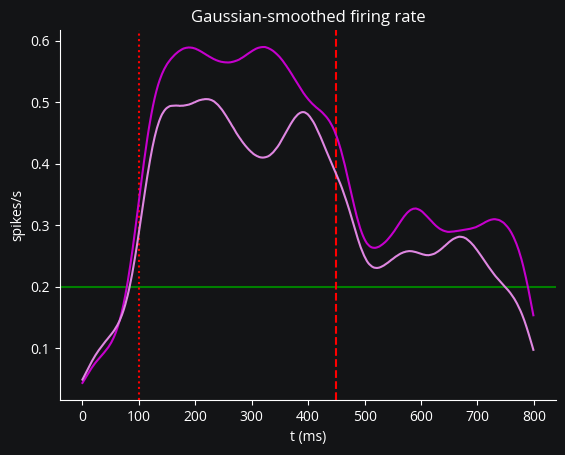

In [20]:
from scipy.stats import norm
kernel = norm.pdf(np.linspace(-75, 75, 151), scale=25)  # 25-ms σ Gaussian window
smoothed1 = np.convolve(ctrl_loop.z[0, :], kernel, mode='same')
smoothed2 = np.convolve(ctrl_loop.z[1, :], kernel, mode='same')
plt.axhline(y_ref, c='g')
plt.axvline(T0, c='r', ls=':')
plt.axvline(T0+T1, c='r', ls='--')
plt.xlabel("t (ms)")
plt.ylabel("spikes/s")
plt.title("Gaussian-smoothed firing rate")
plt.plot(smoothed1, c=c1)
plt.plot(smoothed2, c=c2);